# Version 1.0

## Data Sources

**OpenWeatherMap**: Smooth data and accurate compared to Google Weather data 

**Open-Mateo**: Very quick to download and free, also provides ensemble forecasting for day ahead timeframe

    Note: Convention to put the target column in the first column (index = 0)

## Regression
**Still to be hyperparamater tuned, to serve as baseline for future models**

- Random Forests
- kNN 
- xGBoost 
- Ridge 

**Notes:**
- Very lightweight models and trains fast on Laptop resources, able to track the seasonality of the wind speed.
- Easily able to incorporate uni-variate and multi-variate structures where the multi-variate forecasting is slightly more acurate.

- Rollout does not work as well as having multiple outputs

**Preliminary results**
- The OWM data was proved more suitable for the models to adjust and learn

**To-do**

- Tune hyperparameters
- Play with the windowsize

## Deep-Learning

**PyTorch vs TensorFlow**

[Read the differences ](https://www.turing.com/kb/pytorch-vs-tensorflow)

**Still to be designed and tested**
- NN
- CNN
- RNN
- LSTM
- GNN
- LGBM

_Examples at:_

[Set Scholars](https://setscholars.net/)





# Imports

In [1]:
from shared_utilities import *

# Utilities

In [68]:
def setup_data(data_ = f'data.csv', train_ = False, uni = True, window_size = 24*4, step = 24, sanity_check = False, tensor_ = False, inc = 4):
    if uni:
        column_ = 2
    else:
        column_ = None

    dm = WeatherDataModule(data_dir=data_, 
                        window_size=window_size, column=column_,
                        batch_size=32, step_=step, 
                        normalize_=True, return_tensor=tensor_, inc=inc)

    dm.prepare_data()
    dm.setup('')

    if sanity_check:
        plt.plot(np.arange(window_size),dm.f_test[0], label='Input')
        if step == 1:
            plt.scatter(np.arange(window_size, window_size+step),dm.t_test[0], label='Target', s=5, c='r')
        else:
            plt.plot(np.arange(window_size, window_size+step),dm.t_test[0], label='Target', c='r')
        plt.legend()
        plt.show()

    return dm

def plot_models(models, model_names, colors, X, y, height, width, interval, window_size, step, inc):
    mse_tracker = []

    fig, axes = plt.subplots(height,width, figsize=(18, 3 * height))

    for i, ax_row in enumerate(axes):
            for j, ax in enumerate(ax_row):
                seed_index = i * 2 + j
                seed = seed_index * interval 

                current_data = X[seed]
                true_data = y[seed]

                average = np.zeros(round(step / inc))

                ax.plot(np.arange(0, window_size, inc), current_data, label='Input')
                ax.plot(np.arange(window_size, window_size+step ,inc), true_data, label='Target', c='blue')

                for model in models:
                    try:
                        pred = model.predict(current_data.reshape(1,-1), verbose = 0).squeeze()
                    except:
                        pred = model.predict(current_data.reshape(1,-1)).squeeze()
                    ax.plot(np.arange(window_size, window_size+step ,inc), pred, label=model_names[models.index(model)], c=colors[models.index(model)])
                    average += pred

                average /= len(models)

                ax.plot(np.arange(window_size, window_size+step, inc), average, label='Average', c='black', linestyle='--')
                
                if i == 0 and j == 0:  
                    ax.legend(loc='upper left')

                ax.set_title(f"Seed: {seed}")


    plt.tight_layout()
    plt.show()

def metrics(models, model_names, X, y, window_size, step):
    mse = []
    for model in models:
        try:
            pred = model.predict(X, verbose=0)
        except:
            pred = model.predict(X)
        mse.append(mean_squared_error(y, pred))
        print(f"MSE for {model_names[models.index(model)]} model: {mse[-1]}")

    plt.figure(figsize=(8, 6))  
    plt.bar(model_names, mse)
    plt.xlabel('Models')
    plt.ylabel('Normalized Mean Squared Error (MSE)')
    plt.title('MSE for Different Models')
    plt.show()

def plot_rollouts(models, model_names, colors, X, y, height, width, interval, window_size, step):
    mse_tracker = []

    fig, axes = plt.subplots(height,width, figsize=(18, 3 * height))

    for i, ax_row in enumerate(axes):
            for j, ax in enumerate(ax_row):
                seed_index = i * 2 + j
                seed = seed_index * interval 

                current_data = X[seed]
                true_data = y[seed:seed + step]

                average = np.zeros(step)

                ax.plot(np.arange(window_size), current_data, label='Input')
                ax.plot(np.arange(window_size, window_size+step), true_data, label='Target', c='blue')

                for model in models:
                    pred = rollouts(model, current_data, step)
                    ax.plot(np.arange(window_size, window_size+step), pred, label=model_names[models.index(model)], c=colors[models.index(model)])
                    average += pred

                average /= len(models)

                ax.plot(np.arange(window_size, window_size+step), average, label='Average', c='black', linestyle='--')
                
                if i == 0 and j == 0:  
                    ax.legend(loc='upper left')

                ax.set_title(f"Seed: {seed}")


    plt.tight_layout()
    plt.show()

def rollouts(model, X, step=38):
    forecast = []
    for _ in range(step):
        try:
            pred = model.predict(X.reshape(1, -1), verbose=0)
        except:
            pred = model.predict(X.reshape(1, -1))
        forecast.append(pred)
        X = np.append(X[1:], pred)
    return np.array(forecast).flatten()

class WeatherDataModule(L.LightningDataModule):
    def __init__(self, data_dir="data\current_weather_data.csv", index_='timestamp', 
                 column=0, batch_size=64, window_size=5, normalize_=False,
                 date_range = None, step_ = 24, return_tensor = True, inc = 4):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.index_ = index_
        self.column = column
        self.date_range = date_range
        self.window_size = window_size
        self.step_ = step_
        self.return_tensor = return_tensor
        self.inc = inc
        self.normalize_ = normalize_

    def prepare_data(self):
        df_ = pd.read_csv(self.data_dir, index_col=self.index_, parse_dates=True)
        if self.date_range != None:
            df_ = df_[self.date_range]
        
        if self.column == None:
            self.df = df_
        else:
            self.df = df_.iloc[:,self.column]
        
        if self.normalize_:
            self.scaler = MinMaxScaler()
            self.scaler.fit(self.df.values.reshape(-1, 1))
            self.df = self.normalize(self.df)

        self.windows, self.targets, self.s_t, self.s_f = self.window_step(self.df, self.step_, inc = self.inc)

    def window_step(self, dataset, step_, inc ):
        """Transform a time series into a prediction dataset
        
        Args:
            dataset: A numpy array of time series, first dimension is the time steps
            lookback: Size of window for prediction
        """
        X, y, st, sf = [], [], [], []
        for i in range(len(dataset)-self.window_size - step_ * inc):
            feature = dataset[i:i+self.window_size]
            target = dataset[i+self.window_size:i+self.window_size+step_]
            window = dataset[i:i+self.window_size:inc]
            stagered = dataset[i+self.window_size:i+self.window_size+step_:inc]
            X.append(feature)
            y.append(target)
            st.append(stagered)
            sf.append(window)

        if self.return_tensor:
            X_r = torch.tensor(np.array(X))
            y_r = torch.tensor(np.array(y))
            return X_r.float(), y_r.float()
        else:
            return np.array(X).squeeze(), np.array(y).squeeze(), np.array(st).squeeze(), np.array(sf).squeeze()
    
    def normalize(self, series):
        if self.column == None:
            return pd.DataFrame(self.scaler.fit_transform(series), index=series.index)
        else:
            return pd.DataFrame(self.scaler.fit_transform(series.values.reshape(-1, 1)), index=series.index)
    
    def inverse_normalze(self, series):
        if self.column == None:
            return pd.DataFrame(self.scaler.inverse_transform(series), index=series.index)
        else:
            return pd.DataFrame(self.scaler.inverse_transform(series.values.reshape(-1, 1)), index=series.index)
    
    def inverse_single_column(self, series):
        if self.column == None:
            zeros_ = pd.DataFrame(np.zeros((series.shape[0], self.df.shape[1])))
            zeros_[target_col] = series 
            return pd.DataFrame(self.scaler.inverse_transform(zeros_))[target_col]
        else:
            return pd.DataFrame(self.scaler.inverse_transform(series.reshape(-1, 1)))

    def setup(self, stage: str):
        self.split = [round(len(self.df) * 0.7), round(len(self.df) * 0.9)]

        if self.inc != 1:
            self.f_train, self.t_train = self.s_f[:self.split[0]], self.s_t[:self.split[0]]
            self.f_valid, self.t_valid = self.s_f[self.split[0]:self.split[1]], self.s_t[self.split[0]:self.split[1]]
            self.f_test, self.t_test = self.s_f[self.split[1]:], self.s_t[self.split[1]:]

            self.plot_f_train, self.plot_t_train = self.windows[:self.split[0]], self.targets[:self.split[0]]
            self.plot_f_valid, self.plot_t_valid = self.windows[self.split[0]:self.split[1]], self.targets[self.split[0]:self.split[1]]
            self.plot_f_test, self.plot_t_test = self.windows[self.split[1]:], self.targets[self.split[1]:]
        else:
            self.f_train, self.t_train = self.windows[:self.split[0]], self.targets[:self.split[0]]
            self.f_valid, self.t_valid = self.windows[self.split[0]:self.split[1]], self.targets[self.split[0]:self.split[1]]
            self.f_test, self.t_test = self.windows[self.split[1]:], self.targets[self.split[1]:]
        
        print(f'Train: {self.f_train.shape}\nValid: {self.f_valid.shape}\nTest: {self.f_test.shape}')

    def train_dataloader(self):
        return DataLoader(TensorDataset(self.f_train, self.t_train), batch_size=self.batch_size, shuffle=True, drop_last=True)

    def val_dataloader(self):
        return DataLoader(TensorDataset(self.f_train, self.t_train), batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(TensorDataset(self.f_train, self.t_train), batch_size=self.batch_size, shuffle=False)

    # def predict_dataloader(self):
    #     return DataLoader(self.mnist_predict, batch_size=self.batch_size, shuffle=False)



# Setup

In [70]:
window_size = 24*10
step = 38
inc = 4
source = 'OWM'
load_folder = 'stagger'

dm = setup_data(data_=f'ERA5_Data\ERA5_Reanalysis.csv', train_ = False, uni = True, window_size = window_size, step = step, sanity_check = False, tensor_=False, inc = inc)

# dm = setup_data(data_=f'data\WindPowerAggregated_Eskom.csv', train_ = False, uni = True, window_size = window_size, step = step, sanity_check = False, tensor_=False)

rfr_model, xgb_model, knn_model, ridge_model = load_models(dm = dm, folder=load_folder, window_size=window_size, step=step)

# load_folder = 'deep_models'

# model_dnn= tf.keras.models.load_model(f"{load_folder}/keras_model_DNN_ws_{window_size}_{step}_{source}.h5")
# model_lstm= tf.keras.models.load_model(f"{load_folder}/keras_model_LSTM_ws_{window_size}_{step}_{source}.h5")
# model_gru= tf.keras.models.load_model(f"{load_folder}/keras_model_GRU_ws_{window_size}_{step}_{source}.h5")
# model_cnn= tf.keras.models.load_model(f"{load_folder}/keras_model_CNN_ws_{window_size}_{step}_{source}.h5")
# model_test = tf.keras.models.load_model(f"{load_folder}/keras_model_test_ws_{window_size}_{step}_{source}.h5")

Train: (6132, 60)
Valid: (1752, 60)
Test: (484, 60)
Models loaded...


c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:40:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


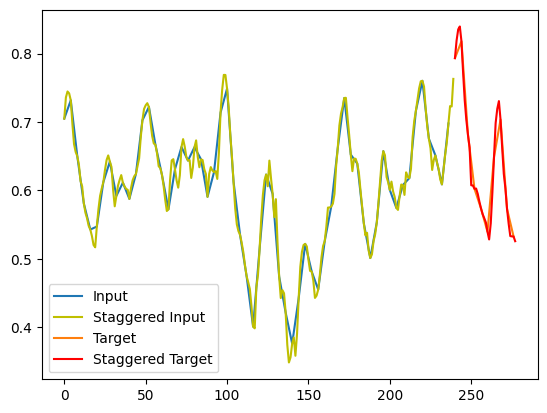

In [71]:
plt.plot(np.arange(0, window_size, inc), dm.f_test[0], label='Input')
plt.plot(np.arange(0, window_size), dm.plot_f_test[0], label='Staggered Input', c='y')
plt.plot(np.arange(window_size, window_size+step, inc),dm.t_test[0], label='Target')
plt.plot(np.arange(window_size, window_size+step),dm.plot_t_test[0], label='Staggered Target', c='r')
plt.legend()
plt.show()

# Inspect

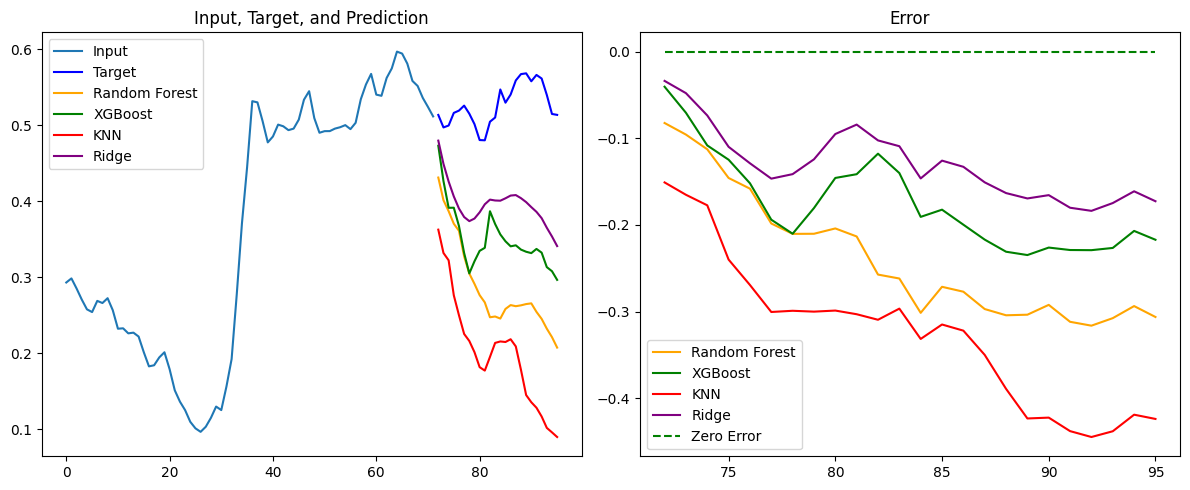

In [42]:
seed = 10

X = dm.f_valid[seed]
y = dm.t_valid[seed]

models = [rfr_model, xgb_model, knn_model, ridge_model] #, model_dnn, model_lstm, model_gru, model_cnn]
model_names = ['Random Forest', 'XGBoost', 'KNN', 'Ridge', 'DNN', 'LSTM', 'GRU', 'CNN']
colors = ['orange', 'green', 'red', 'purple', 'blue', 'black', 'brown', 'pink']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(np.arange(window_size), X, label='Input')
ax1.plot(np.arange(window_size, window_size+step), y, label='Target', c='blue')


for model in models:
    try:
        pred = model.predict(X.reshape(1, -1), verbose=0).squeeze()
    except:
        pred = model.predict(X.reshape(1, -1)).squeeze()
    ax1.plot(np.arange(window_size, window_size+step), pred, label=model_names[models.index(model)], c=colors[models.index(model)])
    errors = pred - y
    ax2.plot(np.arange(window_size, window_size+step), errors, label= model_names[models.index(model)], c=colors[models.index(model)])

ax1.legend()

ax2.plot(np.arange(window_size, window_size+step), np.zeros(step), label='Zero Error', c='green', linestyle='--')
ax2.legend()

ax1.set_title('Input, Target, and Prediction')
ax2.set_title('Error')

plt.tight_layout()  
plt.show()

MSE for RFR model: 0.09453706846810364
MSE for XGB model: 0.08290716791108348
MSE for KNN model: 0.15757374539298558
MSE for Ridge model: 0.03956409266965205


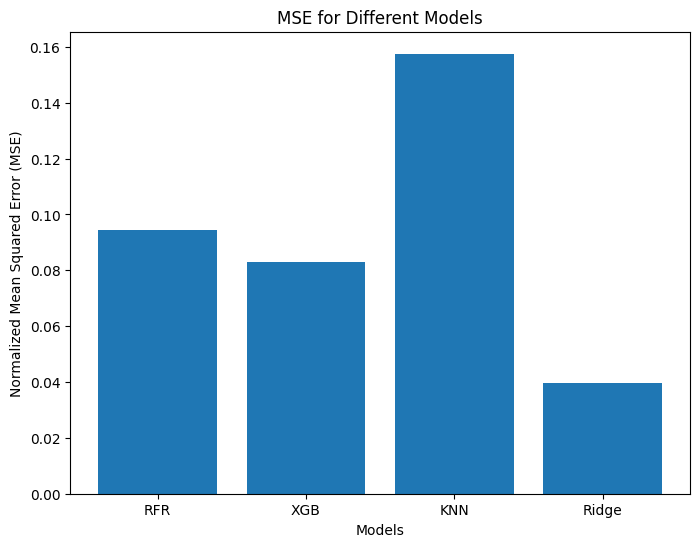

In [72]:
models = [rfr_model, xgb_model, knn_model, ridge_model] #, model_dnn, model_lstm, model_gru, model_cnn] # , model_test]
model_names = ['RFR', 'XGB', 'KNN', 'Ridge']  #, 'DNN', 'LSTM', 'GRU', 'CNN'] #, 'test']
colors = ['green', 'red', 'violet', 'yellow', 'teal', 'blue', 'orange', 'brown', 'pink']

metrics(models, model_names, dm.f_test, dm.t_test, window_size, step)
   

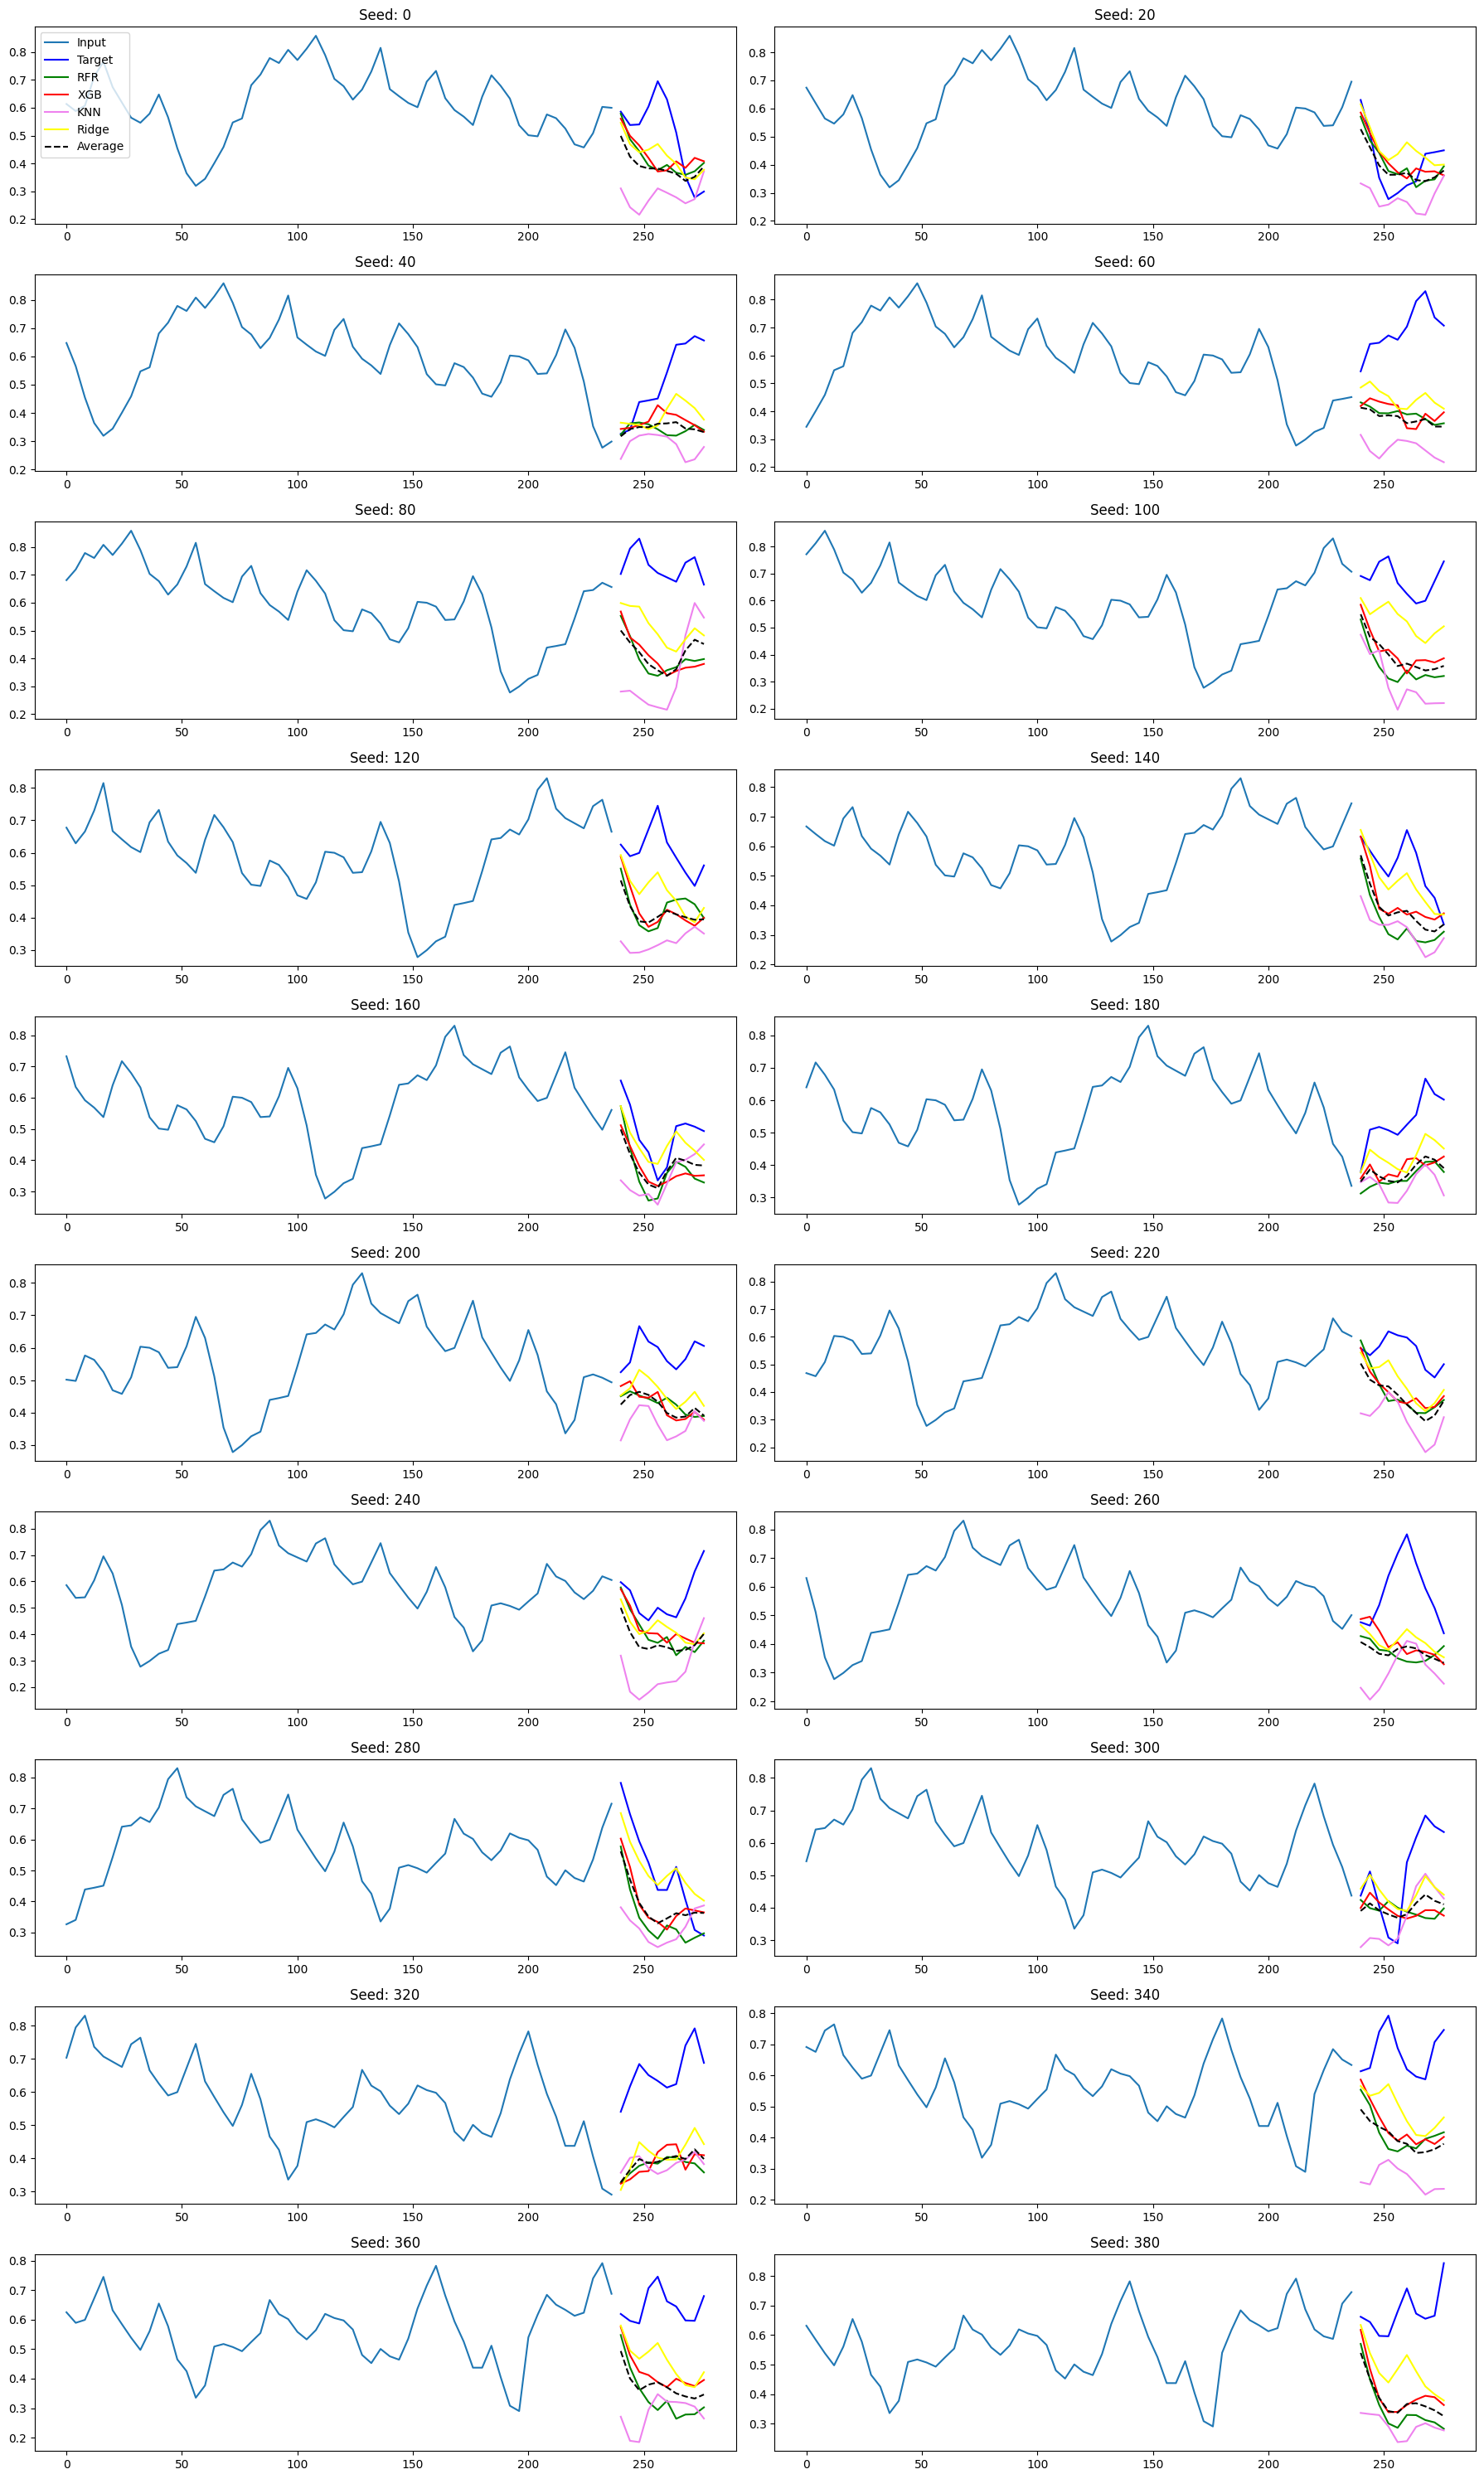

In [74]:
plot_models(models, model_names, colors, dm.f_train, dm.t_train, height=10, width=2, interval=20, window_size=window_size, step=step, inc=inc)

# OpenMeteo forecasts

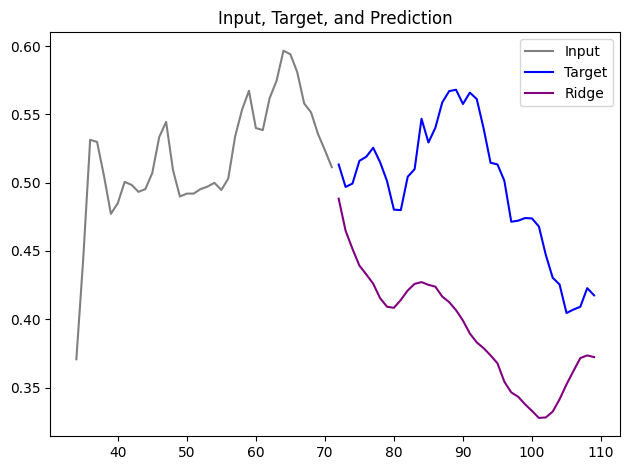

In [7]:
seed = 10

X = dm.f_valid[seed]
y = dm.t_valid[seed]

models = [rfr_model, xgb_model, knn_model, ridge_model] #, model_dnn, model_lstm, model_gru, model_cnn]
model_names = ['Random Forest', 'XGBoost', 'KNN', 'Ridge', 'DNN', 'LSTM', 'GRU', 'CNN']
colors = ['orange', 'green', 'pink', 'purple', 'blue', 'black', 'brown', 'red']

plt.plot(np.arange(window_size - step, window_size), X[window_size - step: window_size], label='Input', c='gray')
plt.plot(np.arange(window_size, window_size+step), y, label='Target', c='blue')

mse_prev = 100
best_pred = None

for model in models:
    try:
        pred = model.predict(X.reshape(1, -1), verbose=0).squeeze()
    except:
        pred = model.predict(X.reshape(1, -1)).squeeze()
    mse = mean_squared_error(y, pred)
    if mse < mse_prev:
        best_pred = pred
        mse_prev = mse
    

plt.plot(np.arange(window_size, window_size+step), best_pred, label=model_names[models.index(model)], c=colors[models.index(model)])

plt.legend()


plt.title('Input, Target, and Prediction')

plt.tight_layout()  
plt.show()

# Rollout

In [13]:
window_size = 24*4
step = 1
source = 'OWM'
load_folder = 'ERA5_models'

dm = setup_data(data_=f'ERA5_Data\ERA5_Reanalysis.csv', train_ = False, uni = True, window_size = window_size, step = step, sanity_check = False, tensor_=False)

# dm = setup_data(data_=f'data\WindPowerAggregated_Eskom.csv', train_ = False, uni = True, window_size = window_size, step = step, sanity_check = False, tensor_=False)

rfr_model, xgb_model, knn_model, ridge_model = load_models(dm = dm, folder=load_folder, window_size=window_size, step=step)

model_dnn= tf.keras.models.load_model(f"{load_folder}/keras_model_DNN_ws_{window_size}_{step}_{source}.h5")
model_lstm= tf.keras.models.load_model(f"{load_folder}/keras_model_LSTM_ws_{window_size}_{step}_{source}.h5")
model_gru= tf.keras.models.load_model(f"{load_folder}/keras_model_GRU_ws_{window_size}_{step}_{source}.h5")
model_cnn= tf.keras.models.load_model(f"{load_folder}/keras_model_CNN_ws_{window_size}_{step}_{source}.h5")


Train: (6132, 96)
Valid: (1752, 96)
Test: (779, 96)
Models loaded...


c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:36:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


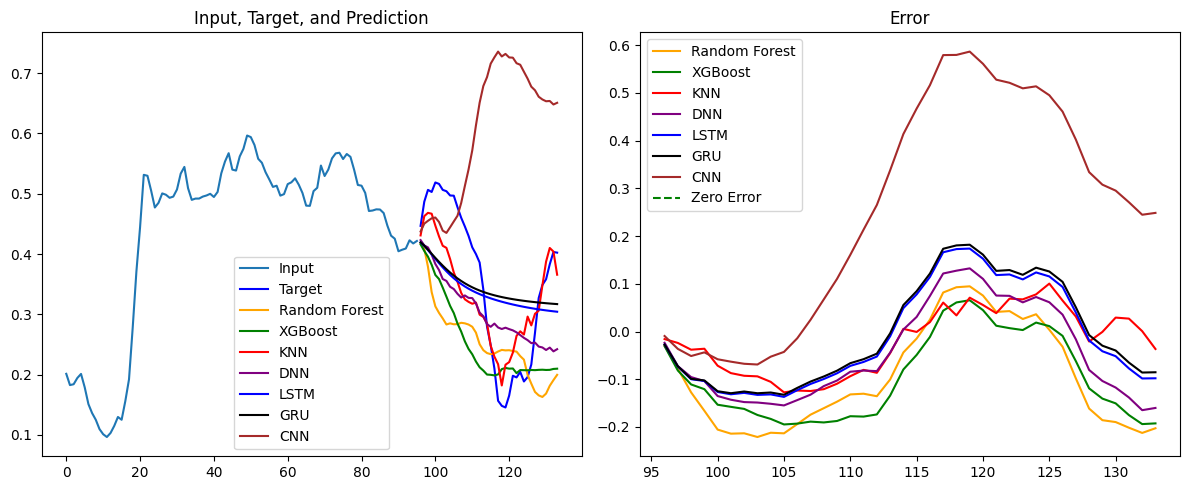

In [16]:
seed = 25

X = dm.f_valid[seed]
y = dm.t_valid[seed: seed + 38]

models = [rfr_model, xgb_model, knn_model,  model_dnn, model_lstm, model_gru, model_cnn] # ridge_model,
model_names = ['Random Forest', 'XGBoost', 'KNN', 'DNN', 'LSTM', 'GRU', 'CNN'] # 'Ridge', 
colors = ['orange', 'green', 'red', 'purple', 'blue', 'black', 'brown', 'pink']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


ax1.plot(np.arange(window_size), X, label='Input')
ax1.plot(np.arange(window_size, window_size+38), y, label='Target', c='blue')


for model in models:
    rollout = []
    pred = rollouts(model, X, 38)        

    ax1.plot(np.arange(window_size, window_size+38), pred, label=model_names[models.index(model)], c=colors[models.index(model)])
    errors = pred - y
    ax2.plot(np.arange(window_size, window_size+38), errors, label= model_names[models.index(model)], c=colors[models.index(model)])

ax1.legend()

ax2.plot(np.arange(window_size, window_size+step), np.zeros(step), label='Zero Error', c='green', linestyle='--')
ax2.legend()

ax1.set_title('Input, Target, and Prediction')
ax2.set_title('Error')

plt.tight_layout()  
plt.show()

ValueError: X has 109 features, but RandomForestRegressor is expecting 72 features as input.

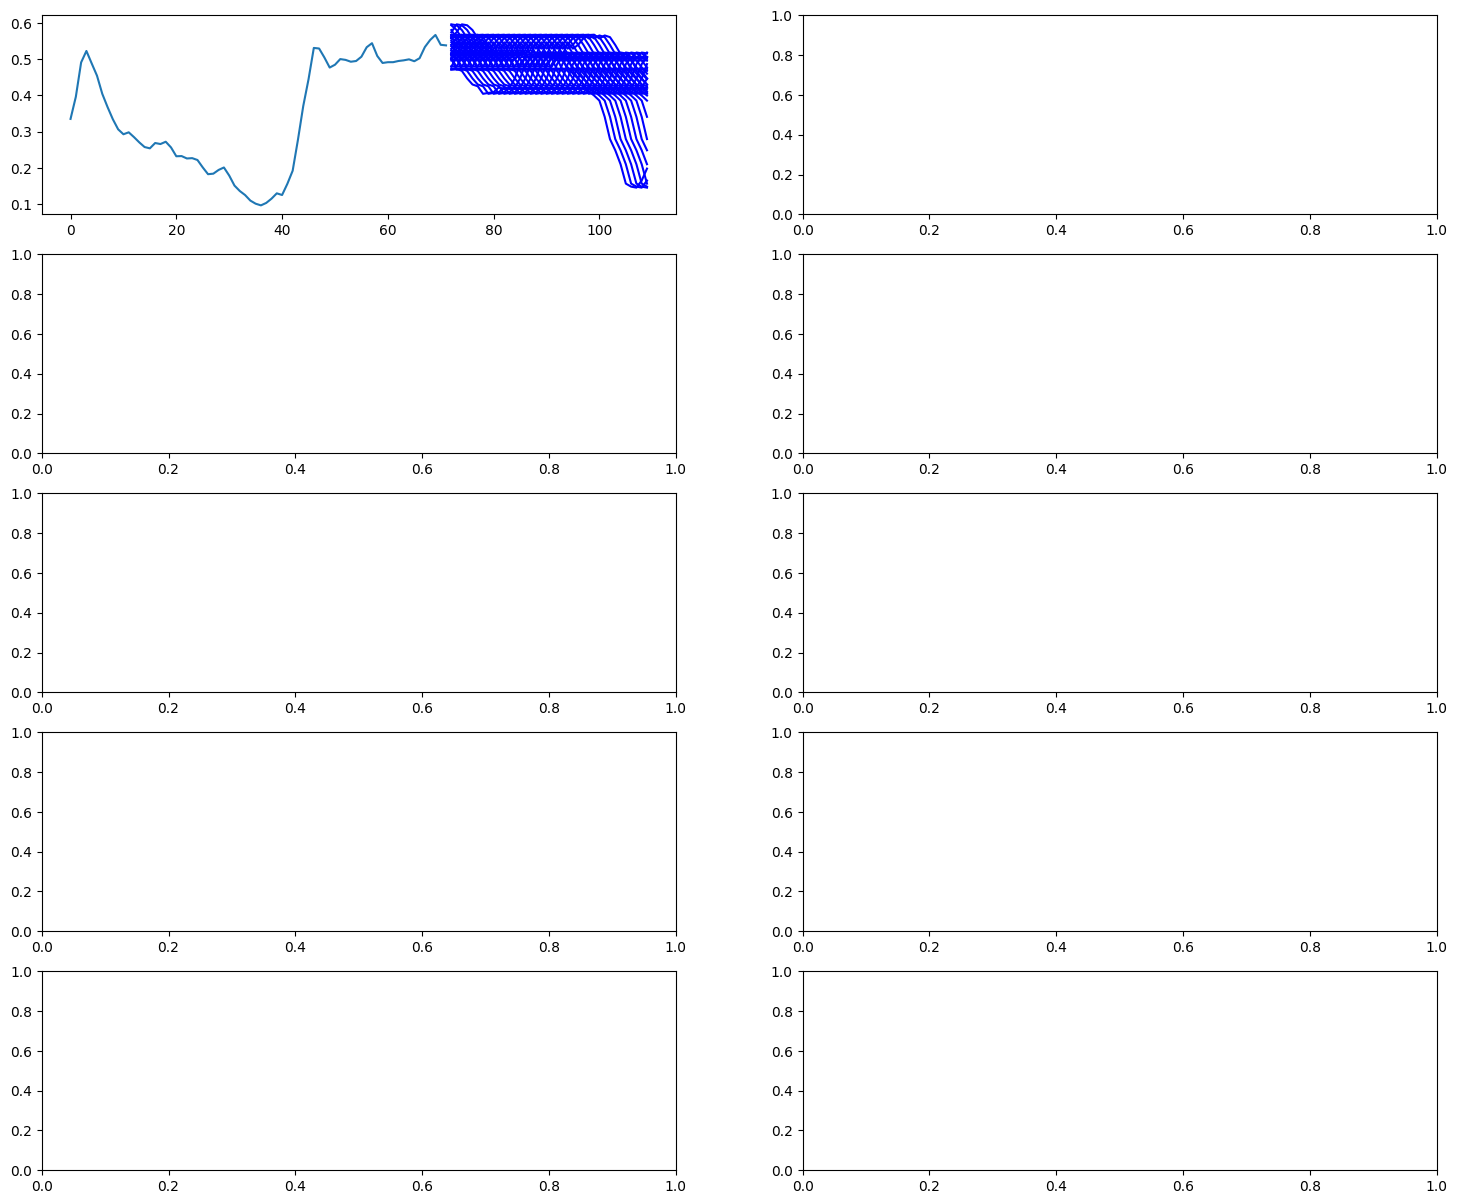

In [50]:
plot_rollouts(models, model_names, colors, dm.f_valid, dm.t_valid, height=5, width=2, interval=25, window_size=window_size, step=38)